In [ ]:
# gather number of units per area from the data

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

# plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams.update({'font.size': 8,'pdf.fonttype':42})

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [32]:
ephys_sessions_path = r"D:\dr_ephys_sessions_list_2024_10_30_0.pkl"

#load from pickle
with open(ephys_sessions_path, 'rb') as f:
    ephys_sessions = pickle.load(f)

In [33]:
n_units_per_area = {
    'session_id':[],
    'project':[],
    'area':[],
    'n_units_no_criteria':[],
    'n_units_medium_criteria':[],
    'n_units_strict_criteria':[],
    'grid_search_array':[],
    'isi_viol_values':[],
    'presence_ratio_values':[],
    'amplitude_cutoff_values':[]
}

isi_viol_values=np.arange(0,0.55,0.05)
presence_ratio_values=np.arange(0.9,1.01,0.01)
amplitude_cutoff_values=np.arange(0.01,0.11,0.01)

start_time=time.time()

for ss in ephys_sessions[:2]:
    session=DynamicRoutingSession(ss)
    session_info=npc_lims.get_session_info(ss)
    units=data_utils.load_trials_or_units(session,'units')
    unique_areas = units['structure'].unique()

    units_medium_criteria = units.query('isi_violations_ratio<=0.5 and presence_ratio>=0.9 and amplitude_cutoff<=0.1')
    units_strict_criteria = units.query('isi_violations_ratio<=0.1 and presence_ratio>=0.99 and amplitude_cutoff<=0.1')

    for area in unique_areas[:2]:

        vary_isi_violations_ratio = []
        vary_presence_ratio = []
        vary_amplitude_cutoff = []

        #make grid search an xarray
        grid_search=np.zeros((len(isi_viol_values),len(presence_ratio_values),len(amplitude_cutoff_values)))

        for iv,isi_viol in enumerate(isi_viol_values):
            for pr,presence_ratio in enumerate(presence_ratio_values):
                for ac,amplitude_cutoff in enumerate(amplitude_cutoff_values):
                    print(f"session {ss}, area {area}, isi_viol {isi_viol}, presence_ratio {presence_ratio}, amplitude_cutoff {amplitude_cutoff}")
                    units_vary_criteria = units.query('structure==@area and isi_violations_ratio<=@isi_viol and \
                                                      presence_ratio>=@presence_ratio and amplitude_cutoff<=@amplitude_cutoff')
                    grid_search[iv,pr,ac]=len(units_vary_criteria)

        n_units_per_area['session_id'].append(str(ss))
        n_units_per_area['project'].append(str(session_info.project))
        n_units_per_area['area'].append(area)
        n_units_per_area['n_units_no_criteria'].append(np.sum(units['structure']==area))
        n_units_per_area['n_units_medium_criteria'].append(np.sum(units_medium_criteria['structure']==area))
        n_units_per_area['n_units_strict_criteria'].append(np.sum(units_strict_criteria['structure']==area))
        n_units_per_area['grid_search_array'].append(grid_search)
        n_units_per_area['isi_viol_values'].append(isi_viol_values)
        n_units_per_area['presence_ratio_values'].append(presence_ratio_values)
        n_units_per_area['amplitude_cutoff_values'].append(amplitude_cutoff_values)

    print(f"session {ss} done, {time.time()-start_time:.2f} seconds elapsed")

# n_units_per_area_df = pd.DataFrame(n_units_per_area)

733780_2024-09-06 cached units loaded
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.01
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.02
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.03
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.04
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.05
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.060000000000000005
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.06999999999999999
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.08
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.09
session 733780_2024-09-06, area APN, isi_viol 0.0, presence_ratio 0.9, amplitude_cutoff 0.0999

In [17]:
#save dataframe
savepath = r"D:\n_units_vary_metrics"
n_units_per_area_df.to_pickle(os.path.join(savepath,'n_units_per_area_1.pkl'))

In [2]:
#load dataframe
savepath = r"D:\n_units_vary_metrics"
n_units_per_area_df = pd.read_pickle(os.path.join(savepath,'n_units_per_area_1.pkl'))

In [ ]:
unique_areas = n_units_per_area_df['area'].unique()

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-05-n_units_per_area"

for aa in unique_areas:
    fig,ax=plt.subplots(3,1,sharex=True)
    # max_n_units=n_units_per_area_df.query('area==@aa')['n_units_no_criteria'].max()
    # max_n_units=100
    n,xbins,patches=ax[0].hist(n_units_per_area_df.query('area==@aa')['n_units_no_criteria'],bins=20,color='b',alpha=0.5,label='no criteria')
    ax[1].hist(n_units_per_area_df.query('area==@aa')['n_units_medium_criteria'],bins=xbins,color='g',alpha=0.5,label='medium criteria')
    ax[2].hist(n_units_per_area_df.query('area==@aa')['n_units_strict_criteria'],bins=xbins,color='r',alpha=0.5,label='strict criteria')
    ax[1].set_ylabel('number of sessions')
    ax[2].set_xlabel('number of units')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    #save figure
    fig.suptitle(f"area {aa}")
    fig.tight_layout()
    if '/' in aa:
        aa=aa.replace('/','-')
    
    fig.savefig(os.path.join(savepath,'plots',f"{aa}.png"))
    plt.close(fig)


In [ ]:
n_units_per_area_df

In [ ]:
aa='ACAd'

area_df=n_units_per_area_df.query('area==@aa')

area_df

In [ ]:
# aa='ACAd'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-05-n_units_per_area\fraction_of_units_by_criteria"

for aa in unique_areas:
    area_df=n_units_per_area_df.query('area==@aa and project=="DynamicRouting"')

    area_df['fraction_units_medium_criteria']=area_df['n_units_medium_criteria']/area_df['n_units_no_criteria']
    area_df['fraction_units_strict_criteria']=area_df['n_units_strict_criteria']/area_df['n_units_no_criteria']

    fig,ax=plt.subplots(1,1)
    #boxplot of fraction of units that pass medium and strict criteria
    area_df.boxplot(column=['fraction_units_medium_criteria','fraction_units_strict_criteria'],ax=ax,grid=False)
    ax.set_ylabel('fraction of units')
    ax.set_title(f"area {aa}")

    if '/' in aa:
        aa=aa.replace('/','-')

    fig.savefig(os.path.join(savepath,f"{aa}_boxplot.png"))
    plt.close(fig)

In [ ]:
#average across areas
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-05-n_units_per_area\fraction_of_units_by_criteria"


area_df=n_units_per_area_df.query('project=="DynamicRouting"')

area_df['fraction_units_medium_criteria']=area_df['n_units_medium_criteria']/area_df['n_units_no_criteria']
area_df['fraction_units_strict_criteria']=area_df['n_units_strict_criteria']/area_df['n_units_no_criteria']

fig,ax=plt.subplots(1,1,figsize=(5,4))
#boxplot of fraction of units that pass medium and strict criteria
area_df.boxplot(column=['fraction_units_medium_criteria','fraction_units_strict_criteria'],ax=ax,grid=False)
ax.set_ylabel('fraction of units')
ax.set_title(f"all_areas")

fig.savefig(os.path.join(savepath,f"all_areas_boxplot.png"))
plt.close(fig)

In [ ]:
# aa='ACAd'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-05-n_units_per_area\fraction_of_sessions_by_criteria"

for aa in unique_areas:

    area_df=n_units_per_area_df.query('area==@aa and project=="DynamicRouting"')

    xvect=np.arange(1,100)

    no_criteria=[]
    no_criteria_n=[]
    medium_criteria=[]
    medium_criteria_n=[]
    strict_criteria=[]
    strict_criteria_n=[]

    for xx in xvect:
        no_criteria.append(len(area_df.query('n_units_no_criteria>=@xx'))/len(area_df))
        medium_criteria.append(len(area_df.query('n_units_medium_criteria>=@xx'))/len(area_df))
        strict_criteria.append(len(area_df.query('n_units_strict_criteria>=@xx'))/len(area_df))

        no_criteria_n.append(len(area_df.query('n_units_no_criteria>=@xx')))
        medium_criteria_n.append(len(area_df.query('n_units_medium_criteria>=@xx')))
        strict_criteria_n.append(len(area_df.query('n_units_strict_criteria>=@xx')))

    no_criteria=np.array(no_criteria)
    medium_criteria=np.array(medium_criteria)
    strict_criteria=np.array(strict_criteria)

    #plot markers and text at 10,20,40, 60 units
    n_unit_list=[5,10,20,40,60,80]

    fig,ax=plt.subplots(1,1)
    ax.plot(xvect,no_criteria,label='no criteria')
    ax.plot(xvect,medium_criteria,label='medium criteria')
    ax.plot(xvect,strict_criteria,label='strict criteria')

    for nn in n_unit_list:
        ax.text(nn,no_criteria[nn],f"{no_criteria_n[nn]}",ha='left',va='bottom')
        ax.text(nn,medium_criteria[nn],f"{medium_criteria_n[nn]}",ha='left',va='bottom')
        ax.text(nn,strict_criteria[nn],f"{strict_criteria_n[nn]}",ha='left',va='bottom')

        ax.plot(nn,no_criteria[nn],'.',color='tab:blue')
        ax.plot(nn,medium_criteria[nn],'.',color='tab:orange')
        ax.plot(nn,strict_criteria[nn],'.',color='tab:green')

    ax.set_xlabel('number of units')
    ax.set_ylabel('fraction of sessions')
    ax.set_title(f"area {aa}")
    ax.legend()

    if '/' in aa:
        aa=aa.replace('/','-')

    # fig.savefig(os.path.join(savepath,f"{aa}_fraction_of_sessions.png"))
    # plt.close(fig)

In [ ]:
no_criteria[nn]

In [ ]:
unique_areas[1239]

In [ ]:
n_units_per_area_df

In [ ]:
DR_10_units=n_units_per_area_df.query('project=="DynamicRouting" and n_units_no_criteria>=10')
fraction_medium_10=len(DR_10_units.query('n_units_medium_criteria<10'))/len(DR_10_units)
fraction_strict_10=len(DR_10_units.query('n_units_strict_criteria<10'))/len(DR_10_units)

DR_20_units=n_units_per_area_df.query('project=="DynamicRouting" and n_units_no_criteria>=20')
fraction_medium_20=len(DR_20_units.query('n_units_medium_criteria<20'))/len(DR_20_units)
fraction_strict_20=len(DR_20_units.query('n_units_strict_criteria<20'))/len(DR_20_units)

DR_40_units=n_units_per_area_df.query('project=="DynamicRouting" and n_units_no_criteria>=40')
fraction_medium_40=len(DR_40_units.query('n_units_medium_criteria<40'))/len(DR_40_units)
fraction_strict_40=len(DR_40_units.query('n_units_strict_criteria<40'))/len(DR_40_units)

#plot fraction of sessions that don't meet criteria
fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.bar(np.array([0,1,2])-0.2,[fraction_medium_10,fraction_medium_20,fraction_medium_40],color='tab:blue',label='medium unit criteria',width=0.4)
ax.bar(np.array([0,1,2])+0.2,[fraction_strict_10,fraction_strict_20,fraction_strict_40],color='tab:red',label='strict unit criteria',width=0.4)

ax.set_ylabel('fraction of area-sessions excluded')
ax.set_xlabel('n units threshold')

ax.set_xticks([0,1,2])
ax.set_xticklabels(['10','20','40'])

ax.legend()

In [3]:
# areas with highest fraction of sessions lost by diff criteria

#with moderate criteria, what fraction of area-sessions have <10 and <20 units?
#with strict criteria, what fraction of area-sessions have <10 and <20 units?

unique_areas = n_units_per_area_df['area'].unique()

area_sessions_excluded={
    'area':[],
    'none_10':[],
    'none_20':[],
    'medium_10':[],
    'medium_20':[],
    'strict_10':[],
    'strict_20':[],
    'medium_10_frac_excl':[],
    'medium_20_frac_excl':[],
    'strict_10_frac_excl':[],
    'strict_20_frac_excl':[],
}

for aa in unique_areas:

    area_df=n_units_per_area_df.query('area==@aa and project=="DynamicRouting"')

    ten_units_df=area_df.query('n_units_no_criteria>=10')
    if len(ten_units_df)<3:
        continue
    none_10=len(ten_units_df)
    medium_10=len(ten_units_df.query('n_units_medium_criteria>=10'))
    strict_10=len(ten_units_df.query('n_units_strict_criteria>=10'))

    medium_10_frac_excl=len(ten_units_df.query('n_units_medium_criteria<10'))/len(ten_units_df)
    strict_10_frac_excl=len(ten_units_df.query('n_units_strict_criteria<10'))/len(ten_units_df)

    twenty_units_df=area_df.query('n_units_no_criteria>=20')
    if len(twenty_units_df)<3:
        none_20=np.nan
        medium_20=np.nan
        strict_20=np.nan

        medium_20_frac_excl=np.nan
        strict_20_frac_excl=np.nan
    else:
        none_20=len(twenty_units_df)
        medium_20=len(twenty_units_df.query('n_units_medium_criteria>=20'))
        strict_20=len(twenty_units_df.query('n_units_strict_criteria>=20'))

        medium_20_frac_excl=len(twenty_units_df.query('n_units_medium_criteria<20'))/len(twenty_units_df)
        strict_20_frac_excl=len(twenty_units_df.query('n_units_strict_criteria<20'))/len(twenty_units_df)

    area_sessions_excluded['area'].append(aa)
    area_sessions_excluded['none_10'].append(none_10)
    area_sessions_excluded['none_20'].append(none_20)
    area_sessions_excluded['medium_10'].append(medium_10)
    area_sessions_excluded['medium_20'].append(medium_20)
    area_sessions_excluded['strict_10'].append(strict_10)
    area_sessions_excluded['strict_20'].append(strict_20)

    area_sessions_excluded['medium_10_frac_excl'].append(medium_10_frac_excl)
    area_sessions_excluded['medium_20_frac_excl'].append(medium_20_frac_excl)
    area_sessions_excluded['strict_10_frac_excl'].append(strict_10_frac_excl)
    area_sessions_excluded['strict_20_frac_excl'].append(strict_20_frac_excl)


In [4]:
area_sessions_excluded_df=pd.DataFrame(area_sessions_excluded)

In [5]:
area_sessions_excluded_df

,area,none_10,none_20,medium_10,medium_20,strict_10,strict_20,medium_10_frac_excl,medium_20_frac_excl,strict_10_frac_excl,strict_20_frac_excl
0,APN,21,17.0,18,13.0,15,10.0,0.142857,0.235294,0.285714,0.411765
1,CA1,75,72.0,72,66.0,66,46.0,0.040000,0.083333,0.120000,0.361111
2,CA3,52,48.0,44,38.0,40,25.0,0.153846,0.208333,0.230769,0.479167
3,CP,76,75.0,74,69.0,69,63.0,0.026316,0.080000,0.092105,0.160000
4,DG,70,66.0,64,53.0,54,37.0,0.085714,0.196970,0.228571,0.439394
...,...,...,...,...,...,...,...,...,...,...,...
125,TRS,6,6.0,5,4.0,4,3.0,0.166667,0.333333,0.333333,0.500000
126,IG,5,4.0,4,0.0,1,0.0,0.200000,1.000000,0.800000,1.000000
127,MPT,3,NaN,3,NaN,2,NaN,0.000000,NaN,0.333333,NaN
128,ICe,4,3.0,2,1.0,1,0.0,0.500000,0.666667,0.750000,1.000000


In [ ]:
# area_sessions_excluded_df.query('area=="SCzo"')

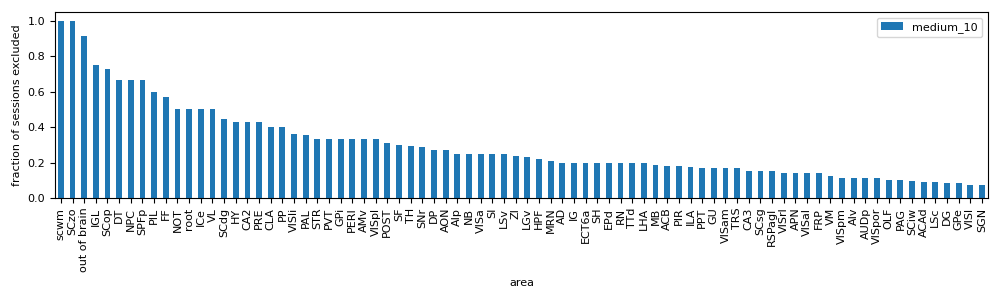

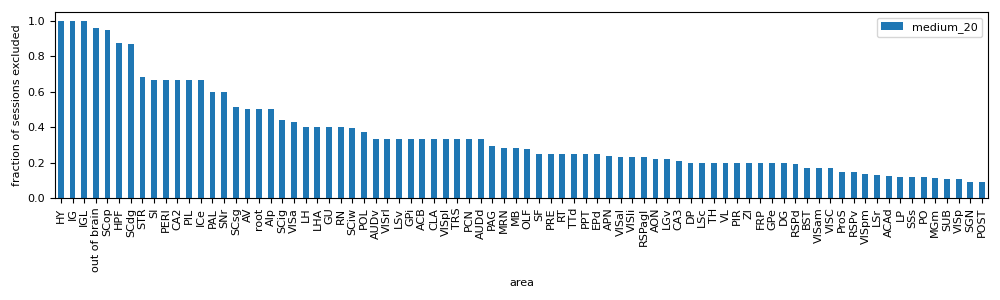

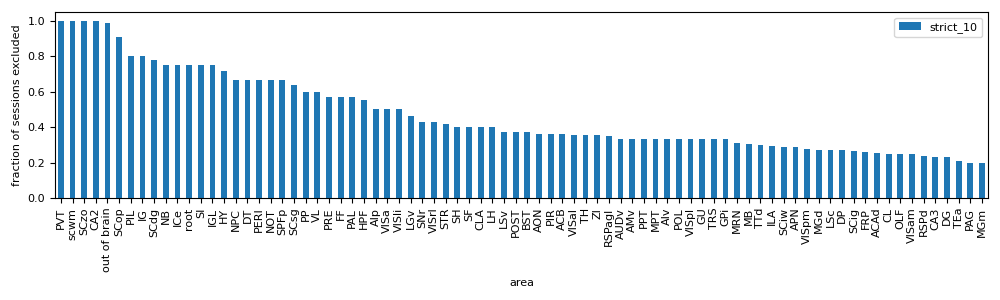

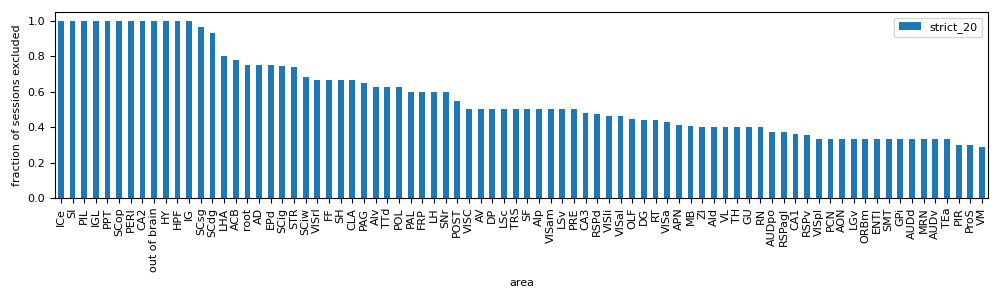

In [6]:
# areas with highest fraction of sessions lost by diff criteria

column_list=['medium_10_frac_excl','medium_20_frac_excl','strict_10_frac_excl','strict_20_frac_excl']

for cc in column_list:

    frac_excl=area_sessions_excluded_df.sort_values(cc,ascending=False)
    fig,ax=plt.subplots(1,1,figsize=(10,3))
    frac_excl[:80].plot(x='area',y=cc,kind='bar',ax=ax,color='tab:blue',label=cc[:9])
    ax.set_ylabel('fraction of sessions excluded')
    fig.tight_layout()


In [ ]:
area_sessions_excluded_df

In [9]:
area_sessions_excluded_df.query('none_10>=3 and medium_10<3')['area'].values

array(['SPFp', 'PVT', 'PERI', 'scwm', 'AMv', 'GPi', 'VISpl', 'root', 'DT',
       'PIL', 'SCzo', 'IGL', 'NPC', 'ICe'], dtype=object)

In [10]:
area_sessions_excluded_df.query('none_20>=3 and medium_20<3')['area'].values

array(['HY', 'PERI', 'AV', 'GPi', 'HPF', 'CLA', 'VISpl', 'root', 'AIp',
       'SCdg', 'SCop', 'PIL', 'CA2', 'SNr', 'IGL', 'PCN', 'SI', 'IG',
       'ICe'], dtype=object)

In [ ]:
area_sessions_excluded_df.query('none_40>=3 and medium_40<3')['area'].values

In [17]:
#examine grid search array for optimal combination of criteria

# grid_search = [isi_viol, presence_ratio, amplitude_cutoff]
isi_viol_values=np.arange(0,0.55,0.05)
presence_ratio_values=np.arange(0.9,1.01,0.01)
amplitude_cutoff_values=np.arange(0.01,0.11,0.01)

sel_area='MOs'
area_table=n_units_per_area_df.query('area==@sel_area and project=="DynamicRouting"')
area_table

,session_id,project,area,n_units_no_criteria,n_units_medium_criteria,n_units_strict_criteria,grid_search_array,isi_viol_values,presence_ratio_values,amplitude_cutoff_values
11,733780_2024-09-06,DynamicRouting,MOs,427,260,158,"[[[73.0, 73.0, 73.0, 73.0, 73.0, 73.0, 73.0, 7...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."
27,733780_2024-09-05,DynamicRouting,MOs,182,119,73,"[[[45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 4...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."
57,733780_2024-09-04,DynamicRouting,MOs,797,544,316,"[[[153.0, 153.0, 153.0, 153.0, 153.0, 153.0, 1...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."
91,733780_2024-09-03,DynamicRouting,MOs,888,307,127,"[[[77.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 7...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."
131,733780_2024-08-29,DynamicRouting,MOs,530,212,94,"[[[61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 6...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."
...,...,...,...,...,...,...,...,...,...,...
3133,636766_2023-01-24,DynamicRouting,MOs,293,134,82,"[[[40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 41.0, 4...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."
3146,636766_2023-01-23,DynamicRouting,MOs,277,90,31,"[[[23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 2...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."
3297,626791_2022-08-17,DynamicRouting,MOs,24,12,6,"[[[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."
3314,626791_2022-08-16,DynamicRouting,MOs,113,50,22,"[[[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 1...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0....","[0.01, 0.02, 0.03, 0.04, 0.05, 0.0600000000000..."


In [5]:
one_row=area_table.iloc[0]

In [8]:
test_array=(one_row['grid_search_array']/one_row['n_units_no_criteria'])
test_array

array([[[0.17096019, 0.17096019, 0.17096019, ..., 0.17096019,
         0.17096019, 0.17096019],
        [0.16159251, 0.16159251, 0.16159251, ..., 0.16159251,
         0.16159251, 0.16159251],
        [0.15690867, 0.15690867, 0.15690867, ..., 0.15690867,
         0.15690867, 0.15690867],
        ...,
        [0.1264637 , 0.1264637 , 0.1264637 , ..., 0.1264637 ,
         0.1264637 , 0.1264637 ],
        [0.11241218, 0.11241218, 0.11241218, ..., 0.11241218,
         0.11241218, 0.11241218],
        [0.09836066, 0.09836066, 0.09836066, ..., 0.09836066,
         0.09836066, 0.09836066]],

       [[0.3559719 , 0.3559719 , 0.3559719 , ..., 0.3559719 ,
         0.3559719 , 0.3559719 ],
        [0.34660422, 0.34660422, 0.34660422, ..., 0.34660422,
         0.34660422, 0.34660422],
        [0.34192037, 0.34192037, 0.34192037, ..., 0.34192037,
         0.34192037, 0.34192037],
        ...,
        [0.30210773, 0.30210773, 0.30210773, ..., 0.30210773,
         0.30210773, 0.30210773],
        [0.2

In [22]:
# isi_viol_values
presence_ratio_values

array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

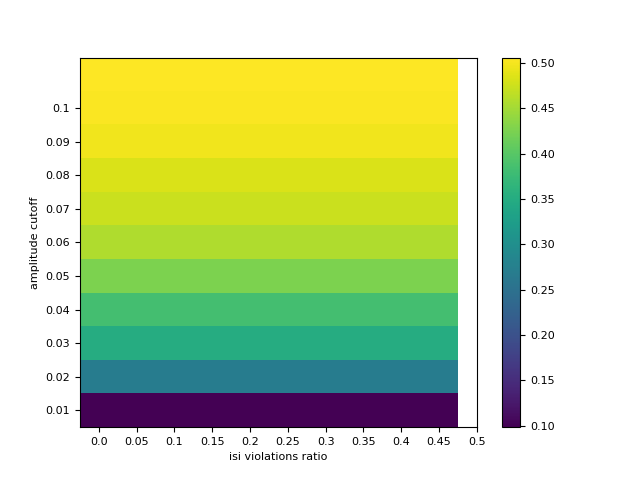

In [28]:
#fix one dimension
# isi_viol_ind=2
# test_array_fixed_isi=test_array[isi_viol_ind,:,:]
presence_ratio_ind=-1
test_array_fixed_isi=test_array[:,presence_ratio_ind,:]

#make heatmap
fig,ax=plt.subplots(1,1)
cax=ax.imshow(test_array_fixed_isi,origin='lower',cmap='viridis',aspect='auto',interpolation='none')
ax.set_xlabel('isi violations ratio')
# ax.set_xlabel('presence ratio')
ax.set_ylabel('amplitude cutoff')

ax.set_xticks(np.arange(len(isi_viol_values)))
ax.set_xticklabels(np.round(isi_viol_values,decimals=3))
# ax.set_xticks(np.arange(len(presence_ratio_values)))
# ax.set_xticklabels(np.round(presence_ratio_values,decimals=3))
ax.set_yticks(np.arange(len(amplitude_cutoff_values)))
ax.set_yticklabels(np.round(amplitude_cutoff_values,decimals=3))

#colorbar
cbar=fig.colorbar(cax,ax=ax)

In [29]:
# np.nanmean(area_table['grid_search_array'].values)
test_array_fixed_isi

array([[0.09836066, 0.09836066, 0.09836066, 0.09836066, 0.09836066,
        0.09836066, 0.09836066, 0.09836066, 0.09836066, 0.09836066],
       [0.26932084, 0.26932084, 0.26932084, 0.26932084, 0.26932084,
        0.26932084, 0.26932084, 0.26932084, 0.26932084, 0.26932084],
       [0.35128806, 0.35128806, 0.35128806, 0.35128806, 0.35128806,
        0.35128806, 0.35128806, 0.35128806, 0.35128806, 0.35128806],
       [0.38407494, 0.38407494, 0.38407494, 0.38407494, 0.38407494,
        0.38407494, 0.38407494, 0.38407494, 0.38407494, 0.38407494],
       [0.42622951, 0.42622951, 0.42622951, 0.42622951, 0.42622951,
        0.42622951, 0.42622951, 0.42622951, 0.42622951, 0.42622951],
       [0.45667447, 0.45667447, 0.45667447, 0.45667447, 0.45667447,
        0.45667447, 0.45667447, 0.45667447, 0.45667447, 0.45667447],
       [0.47306792, 0.47306792, 0.47306792, 0.47306792, 0.47306792,
        0.47306792, 0.47306792, 0.47306792, 0.47306792, 0.47306792],
       [0.4824356 , 0.4824356 , 0.4824356

In [31]:
area_array=area_table['grid_search_array'].values/area_table['n_units_no_criteria'].values

In [37]:
area_array_mean=np.mean(area_array)

In [52]:
isi_viol_values

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

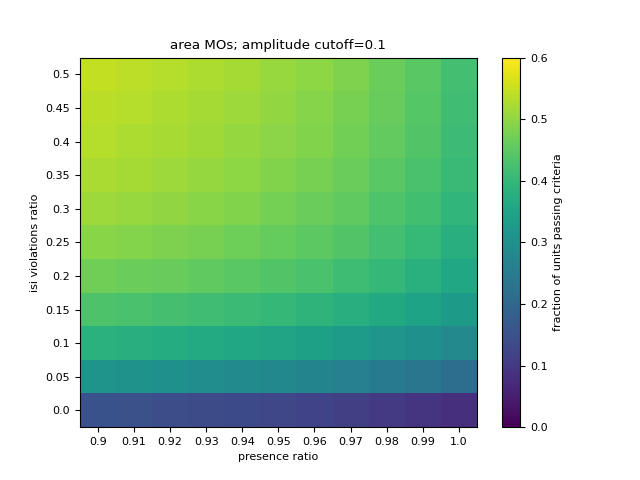

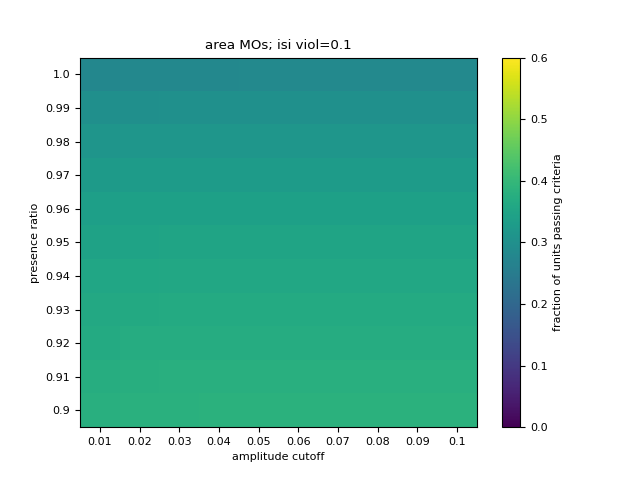

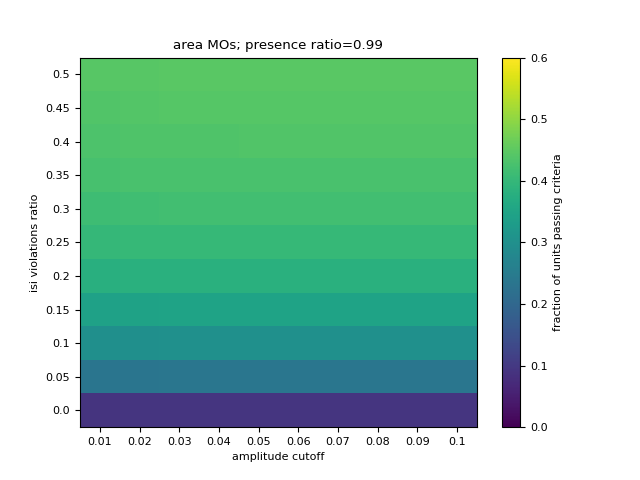

In [61]:
color_range=[0,0.6]
##fix amplitude cutoff##
amplitude_cutoff_ind=-1
area_array_fixed=area_array_mean[:,:,amplitude_cutoff_ind]

#make heatmap
fig,ax=plt.subplots(1,1)
cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none',vmin=color_range[0],vmax=color_range[1])
ax.set_ylabel('isi violations ratio')
ax.set_xlabel('presence ratio')
ax.set_title(f"area {sel_area}; amplitude cutoff={np.round(amplitude_cutoff_values[amplitude_cutoff_ind],decimals=3)}")
ax.set_yticks(np.arange(len(isi_viol_values)))
ax.set_yticklabels(np.round(isi_viol_values,decimals=3))
ax.set_xticks(np.arange(len(presence_ratio_values)))
ax.set_xticklabels(np.round(presence_ratio_values,decimals=3))
#colorbar
cbar=fig.colorbar(cax,ax=ax)
#colorbar label
cbar.set_label('fraction of units passing criteria')


##fix isi violations##
isi_viol_ind=2
area_array_fixed=area_array_mean[isi_viol_ind,:,:]
#make heatmap
fig,ax=plt.subplots(1,1)
cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none',vmin=color_range[0],vmax=color_range[1])
ax.set_ylabel('presence ratio')
ax.set_xlabel('amplitude cutoff')
ax.set_title(f"area {sel_area}; isi viol={np.round(isi_viol_values[isi_viol_ind],decimals=3)}")
ax.set_yticks(np.arange(len(presence_ratio_values)))
ax.set_yticklabels(np.round(presence_ratio_values,decimals=3))
ax.set_xticks(np.arange(len(amplitude_cutoff_values)))
ax.set_xticklabels(np.round(amplitude_cutoff_values,decimals=3))
#colorbar
cbar=fig.colorbar(cax,ax=ax)
#colorbar label
cbar.set_label('fraction of units passing criteria')


#fix presence ratio
presence_ratio_ind=-2
area_array_fixed=area_array_mean[:,presence_ratio_ind,:]
#make heatmap
fig,ax=plt.subplots(1,1)
cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none',vmin=color_range[0],vmax=color_range[1])
ax.set_ylabel('isi violations ratio')
ax.set_xlabel('amplitude cutoff')
ax.set_title(f"area {sel_area}; presence ratio={np.round(presence_ratio_values[presence_ratio_ind],decimals=3)}")
ax.set_yticks(np.arange(len(isi_viol_values)))
ax.set_yticklabels(np.round(isi_viol_values,decimals=3))
ax.set_xticks(np.arange(len(amplitude_cutoff_values)))
ax.set_xticklabels(np.round(amplitude_cutoff_values,decimals=3))
#colorbar
cbar=fig.colorbar(cax,ax=ax)
#colorbar label
cbar.set_label('fraction of units passing criteria')
